In [1]:
import numpy as np
import matplotlib.pyplot as plt
from toksearch_d3d import PtDataSignal

  The MDSplus python module version (HEAD_release_7.139.59) does not match
  the version of the installed MDSplus libraries (unknown_release_0.0.0).
  Upgrade the module using the mdsplus/python/MDSplus directory of the
  MDSplus installation or set PYTHONPATH=/usr/local/mdsplus/python.


In [2]:
shot=203018
x=PtDataSignal('CKXOUT').fetch(shot)
x.keys()

Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.


dict_keys(['data', 'times', 'units'])

In [3]:
times = x['times']
data = x['data']

NYMODEL = 2
NYOUT_PTS = 101
NYPROF = 7

prof_data = data.reshape((-1, NYMODEL, NYOUT_PTS, NYPROF))

dens_profiles = prof_data[:, 1, :, 3]  # 3-- for density || 6 for rotation
rot_profiles = prof_data[:, 1, :, 6]
q_profiles = prof_data[:, 1, :, 2]
pres_profiles = prof_data[:, 1, :, 0]
etemp_profiles = prof_data[:, 1, :, 4]

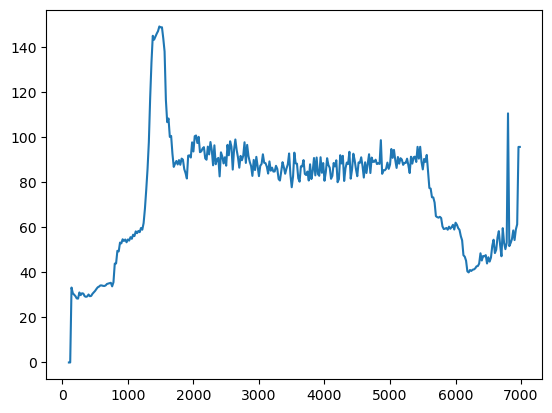

In [6]:
plt.plot(times, rot_profiles[:, 50])

95

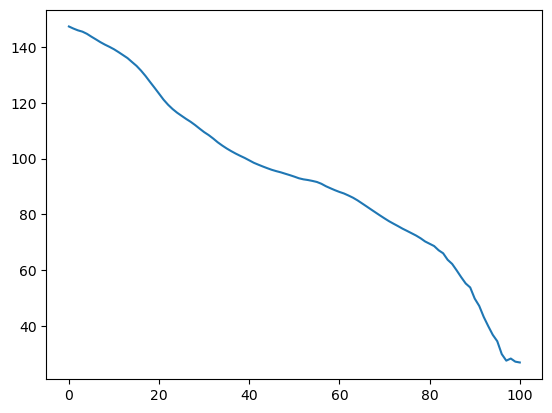

In [14]:
indx = abs(times - 2000).argmin()
# print(indx)
plt.plot(rot_profiles[indx, :])

In [4]:
# sub_indices = (times < 4500) & (times > 1500)
# sub_times = times[sub_indices]
# sub_prof_data = rot_profiles[sub_indices, 0]
# plt.plot(sub_times, sub_prof_data)

In [5]:
def filter_lp(x, prev_y, dt, tau):
    """
    Low-pass filter function.
    
    Args:
        x: Current input value
        prev_y: Previous filtered output value
        dt: Time step
        tau: Time constant (filter strength)
    
    Returns:
        Filtered output value
    """
    return prev_y + dt / (dt + tau) * (x - prev_y)

def apply_lp_filter(data, dt, tau):
    """
    Apply low-pass filter to an array of data.
    
    Args:
        data: Input data array
        dt: Time step (or can be an array of time differences)
        tau: Time constant (controls filter strength)
    
    Returns:
        Filtered data array
    """
    filtered = np.zeros_like(data)
    filtered[0] = data[0]  # Initialize with first value
    
    for i in range(1, len(data)):
        filtered[i] = filter_lp(data[i], filtered[i-1], dt, tau)
    
    return filtered




In [6]:
def interp_full(psi_in, values_in, psi_out):
    """
    Full interpolation function that interpolates from (psi_in, values_in) to psi_out.
    
    Args:
        psi_in: Input psi coordinates (array)
        values_in: Input values at psi_in coordinates (array)
        psi_out: Output psi coordinates where interpolation is desired (array)
    
    Returns:
        Interpolated values at psi_out coordinates
    """
    in_size = len(psi_in)
    out_size = len(psi_out)
    out = np.zeros(out_size)
    
    # Find min and max indices
    j_min = [0, 0]
    j_max = [0, 0]
    
    # Find absolute min and max
    j_min[0] = np.argmin(psi_in)
    j_max[0] = np.argmax(psi_in)
    
    # Find second smallest and second largest
    j_min[1] = j_max[0]
    j_max[1] = j_min[0]
    
    for j in range(in_size):
        if psi_in[j] > psi_in[j_min[0]] and psi_in[j] <= psi_in[j_min[1]]:
            j_min[1] = j
        if psi_in[j] < psi_in[j_max[0]] and psi_in[j] >= psi_in[j_max[1]]:
            j_max[1] = j
    
    # Interpolate for each output point
    for i in range(out_size):
        psi_t = psi_out[i]
        j_high = j_max[0]
        j_low = j_min[0]
        
        # Find bracketing indices
        for j in range(in_size):
            if psi_in[j] > psi_t and psi_in[j] < psi_in[j_high]:
                j_high = j
            elif psi_in[j] < psi_t and psi_in[j] > psi_in[j_low]:
                j_low = j
        
        # Handle extrapolation at boundaries
        if j_high == j_max[0]:
            j_low = j_max[1]
        elif j_low == j_min[0]:
            j_high = j_min[1]
        
        # Linear interpolation
        out_high = values_in[j_high]
        out_low = values_in[j_low]
        psi_n_diff = psi_in[j_high] - psi_in[j_low]
        weight = (psi_t - psi_in[j_low]) / psi_n_diff if abs(psi_n_diff) >= 1e-5 else 0.0
        out[i] = out_low + weight * (out_high - out_low)
    
    return out


def interp_profile(values_in, out_size):
    """
    Interpolate profile from input size to output size using uniform psi grid.
    
    Args:
        values_in: Input profile values (array of length in_size)
        out_size: Desired output size (e.g., 33)
    
    Returns:
        Interpolated profile of length out_size
    """
    in_size = len(values_in)
    
    # Create uniform psi grids
    psi_in = np.linspace(0, 1, in_size)
    psi_out = np.linspace(0, 1, out_size)
    
    return interp_full(psi_in, values_in, psi_out)


def convert_profiles_101_to_33(profiles_101):
    """
    Convert profiles from 101 dimensions to 33 dimensions.
    
    Args:
        profiles_101: Array of shape (..., 101) with profiles to convert
    
    Returns:
        Array of shape (..., 33) with interpolated profiles
    """
    original_shape = profiles_101.shape
    
    # Reshape to (N, 101) where N is product of all dimensions except last
    profiles_flat = profiles_101.reshape(-1, original_shape[-1])
    
    # Interpolate each profile
    profiles_33 = np.array([interp_profile(prof, 33) for prof in profiles_flat])
    
    # Reshape back to original dimensions with 33 instead of 101
    new_shape = original_shape[:-1] + (33,)
    return profiles_33.reshape(new_shape)

In [7]:
tau_dict = {
    'rot':50,
    'ne' : 70,
    'pres' : 10,
    'etemp':10
}

index_map = {
    'rot': 6,
    'ne': 3,
    'pres': 0,
    'etemp': 4
}


In [10]:
# sub_prof33.shape

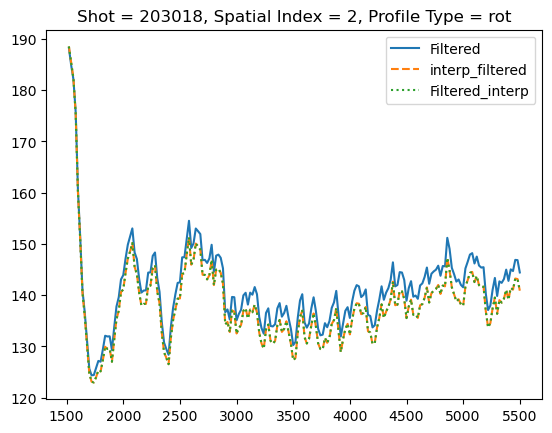

In [17]:
prof_type = 'rot'

prof = prof_data[:,1,:, index_map[prof_type]]

spat_index = 2

sub_indices = (times < 5500) & (times > 1500)
sub_times = times[sub_indices]
sub_prof_data = prof[sub_indices, spat_index]

# Example usage:
dt = np.diff(sub_times).mean()  # Average time step
tau = tau_dict[prof_type]  # Time constant (adjust for desired smoothing)
filtered_data = apply_lp_filter(sub_prof_data, dt, tau)
plt.plot(sub_times, filtered_data, label='Filtered')
# plt.plot(sub_times, sub_prof_data, label='Actual')

# do 33 prof value
prof33 = convert_profiles_101_to_33(prof)
sub_prof33 = prof33[sub_indices, spat_index]
filtered_data33 = apply_lp_filter(sub_prof33, dt, tau)
plt.plot(sub_times, filtered_data33, label='interp_filtered', linestyle='--')
# plt.plot(sub_times, sub_prof33, label='Actual33', linestyle=':')


# first filter data then apply 33 conversion and plot
filtered_full = apply_lp_filter(prof[sub_indices, :], dt, tau)
filtered_interp = convert_profiles_101_to_33(filtered_full)[:, spat_index]
plt.plot(sub_times, filtered_interp, label='Filtered_interp', linestyle=':')

plt.title(f"Shot = {shot}, Spatial Index = {spat_index}, Profile Type = {prof_type}")
plt.legend()

In [69]:
prof33.shape

(345, 33)

In [44]:

# # Example usage:
# dt = np.diff(sub_times).mean()  # Average time step
# tau = 50  # Time constant (adjust for desired smoothing)
# filtered_data = apply_lp_filter(rot_profiles[sub_indices, 0], dt, tau)
# plt.plot(sub_times, filtered_data, label='Filtered')
# plt.plot(sub_times, rot_profiles[sub_indices,0], label='Actual')
# plt.title(f"Shot = {shot}, Spatial Index = 0")
# plt.legend()